In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import rigidbody.kinematics as kine
import rigidbody.plotter as plotter
import rigidbody.ode_solver as ode

Make the plot prettier using Seaborn and tex. You can disable this if you dont have latex in your machine.

In [3]:
plotter.set_context("paper")

Let us write an ordinary differential equation corresponds to a simple ground robot moving in 2d space.

In [7]:
def kinematic_dynamic(x, nu):
    """
    Kinematic of a two-dimensional movement.
    The state x contains (x,y,phi).

    Parameters
    ----------
    t: float
    x: np.ndarray (3,)

    Returns
    -------
    dx_dt: np.ndarray (3,)
    """
    j_inv = kine.inverse_analytical_jacobian_2d(x[-1])
    return j_inv@nu

Now let us simulate a trajectory of this robot. Assume that we can measure and control directly the velocity of the robot.

In [8]:
trajectory_init = np.array([0.,0.,0.])
N_t = 3000
dt = 1e-3
t_span = np.arange(N_t)*dt
trajectory = np.zeros((t_span.shape[0],3))
trajectory[0] = trajectory_init
v = 10*np.ones_like(t_span)
zeros_portion = np.pi*np.zeros((N_t//12,))
ones_portion = np.pi*np.ones((N_t//12,))
phi_dot = np.concatenate([ones_portion,ones_portion,zeros_portion,ones_portion,ones_portion,zeros_portion,ones_portion,ones_portion,zeros_portion,ones_portion,ones_portion,zeros_portion])
# phi_dot = np.random.randn(t_span.shape[0])*np.pi
nu_t = np.block([[v],
                 [np.zeros_like(t_span)],
                [phi_dot]])
nu_t = nu_t.T

Let us now plot the velocity components. Remember this velocity is given in the body axis.

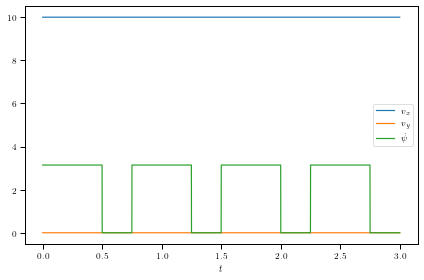

In [9]:
plt.plot(t_span,nu_t, label=[r"$v_x$",r"$v_y$",r"$\dot\psi$"])
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()
# plt.savefig('nu.svg')

Now using the information that we have (velocity in the body frame and a kinematic model in the form of ode), we can estimate the robot location by using an ode solver. Here, we will use a simple euler method to solve the ode.

In [10]:
for i in range(t_span.shape[0]-1):
    trajectory[i+1] = ode.euler_one_step(kinematic_dynamic,trajectory[i],dt,nu_t[i])

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/BasicRigidBody-0.1-py3.9.egg/rigidbody/plotter.py:64: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/BasicRigidBody-0.1-py3.9.egg/rigidbody/plotter.py:68: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


Text(0, 0.5, '$y$')

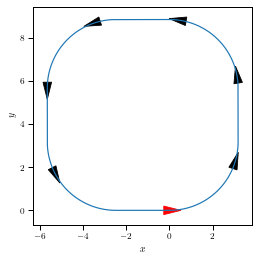

In [11]:
ax = plotter.two_d_trajectory_attitude_plot(trajectory,0.20,400,color="black",initial_color='red')
ax.set_aspect("equal")
# ax.scatter(trajectory[0,0],trajectory[0,1],s=30,color='red')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
# plt.savefig('trajectory.svg')

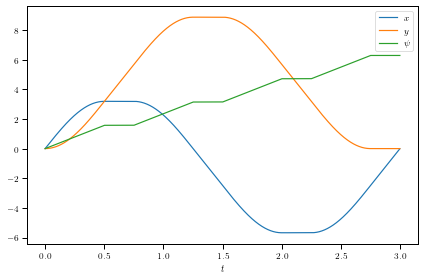

In [12]:
plt.plot(t_span,trajectory, label=[r"$x$",r"$y$",r"$\psi$"])
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()
# plt.savefig('eta.svg')

Suppose now we would like instead to design a controller where the desired trajectory is given like the trajectory above.
That is we use the $x$ and $y$ from the trajectory above as our desired trajectory.
Our task is to come up with a control signal in terms of the forward speed $v_x$ and angular speed $\dot{\psi}$ such that the
robot can follow the desired trajectory even though the initial position is not equal to the initial position of the trajectory.

In [13]:
desired_trajectory = trajectory[:,:2]

Create a controller that would allow the vehicle follows the desired trajectory.
Using a combination of two PI controllers, responsible for maintaining the speed and the angular velocity, we can write
$
\begin{align}
e =& x_d(t)-x(t),\\
v_x(t) =& K_{p,v} \|e(t)\|+ \int_0^t K_{i,v} \|e(s)\| ds,\\
\psi_d =& \text{atan2}(ey,ex),\\
\dot{\psi} =& K_{p,\psi} (\psi_d(t)-\psi(t)) + \int_0^t K_{i,\psi} (\psi_d(s)-\psi(s)) ds.
\end{align}
$



Let us initialize an array for the controlled trajectory.
Here, you can change the initial condition of the robot angle and position to see if the controller can always drive the robot to the desired trajectory.

In [29]:
controlled_trajectory = np.zeros_like(trajectory)
# controlled_trajectory[0] = np.array([0.0,2,-np.pi/2]) # this is easy
# controlled_trajectory[0] = np.array([-0.0,4.5,-np.pi/2]) # this is also fine
# controlled_trajectory[0] = np.array([-1.0,4.5,-np.pi/2]) # this is also fine (still)
controlled_trajectory[0] = np.array([-2.4,4.5,-np.pi/2]) # this is difficult

After trial and errors (a lot of it), we can found a suitable parameters $K_{p,v},K_{i,v},K_{p.\psi},K_{i,\psi}$ that
makes the controller drives the robot to desired trajectory.

We can try any combination of these parameters using an ode solver as before.

In [34]:
K_p_v = 1e1
K_i_v = 1e-2
K_p_psi = 5e1
K_i_psi = 2e-2

max_v_x = 1.0*v[0] #set maximum forward speed
max_psi_dot = 2*ones_portion[0] #set maximum angular speed
sum_norm_e = 0
sum_e_psi = 0
nu_hist = []
for i in range(t_span.shape[0]-1):
    e = desired_trajectory[i,:2] - controlled_trajectory[i,:2]
    norm_e = np.linalg.norm(e)
    v_x = K_p_v*norm_e + K_i_v*sum_norm_e
    v_x = np.minimum(v_x,max_v_x)
    sum_norm_e += norm_e
    psi_d = np.arctan2(e[1],e[0])

    #since psi_d can only be [0,2pi] this need to be handled properly
    if psi_d-controlled_trajectory[i,-1] < -np.pi:
        psi_d=psi_d+2*np.pi#*(controlled_trajectory[i,-1]//2*np.pi)
    elif psi_d-controlled_trajectory[i,-1] > np.pi:
        psi_d=psi_d-2*np.pi#*(controlled_trajectory[i,-1]//2*np.pi)
    else:
        psi_d = psi_d

    e_psi = (psi_d-controlled_trajectory[i,-1])
    sum_e_psi += e_psi
    psi_dot = K_p_psi*e_psi + K_i_psi*sum_e_psi
    psi_dot = np.clip(psi_dot,-max_psi_dot,max_psi_dot)
    nu_ = np.array([v_x,0.,psi_dot])
    nu_hist.append(nu_)
    # controlled_trajectory[i+1] = ode.euler_one_step(kinematic_dynamic,controlled_trajectory[i],dt,nu_)
    controlled_trajectory[i+1] = ode.rk_one_step(kinematic_dynamic,controlled_trajectory[i],dt,nu_)
    # controlled_trajectory[i+1] = controlled_trajectory[i] + dt* kinematic_dynamic(controlled_trajectory[i],nu)
nu_hist = np.stack(nu_hist)

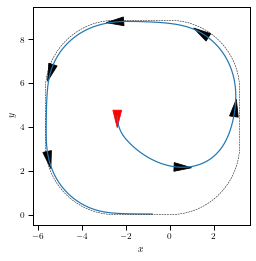

In [35]:
ax = plotter.two_d_trajectory_attitude_plot(controlled_trajectory,0.20,400,initial_color="red")
ax.plot(desired_trajectory[:,0],desired_trajectory[:,1],'--k',linewidth=0.5)
ax.set_aspect("equal")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
plt.savefig('controlled_trajectory.svg')

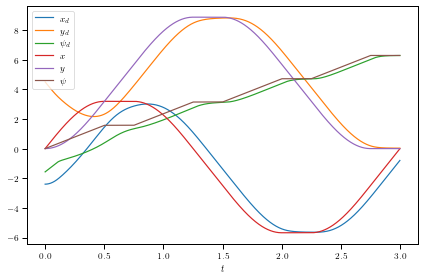

In [36]:
plt.plot(t_span,controlled_trajectory, label=[r"$x_d$",r"$y_d$",r"$\psi_d$"])
plt.plot(t_span,trajectory, label=[r"$x$",r"$y$",r"$\psi$"])
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()
# plt.savefig('eta_controlled.svg')

The plot of the control signals is given below.
We have deliberately restrict the forward speed and the angular velocity speed to match the practical situation.

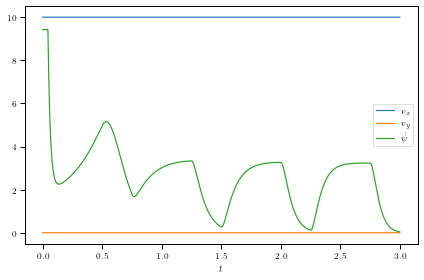

In [33]:
plt.plot(t_span[1:],nu_hist, label=[r"$v_x$",r"$v_y$",r"$\dot\psi$"])
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()